In [4]:
import argparse
import pdb
import sys
import os
import logging

import numpy as np
from scipy.optimize import minimize

sys.path.insert(0, '../../../network')
from network import *
from transfer_functions import LIF, ReLU
from sequences import GaussianSequence
from connectivity import *
from noise import WhiteNoise

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

Network parameters

In [5]:
T = 0.5

N_E = 20000
N_I = 5000

A_EE = 6.3

tau_exc = 2e-2
tau_inh = 5e-3

exc_phi = ReLU(g=12)
inh_phi = ReLU(g=20)

Simulate network

In [7]:
exc = Population(
        N_E,
        tau=tau_exc,
        phi=exc_phi.phi,
        name="exc")

inh = Population(
        N_I,
        tau=tau_inh,
        phi=inh_phi.phi,
        name="inh")

# Build connectivity
conn_EE = SparseConnectivity(source=exc, target=exc, p=0.04, disable_pbar=True)
conn_IE = SparseConnectivity(source=exc, target=inh, p=0.04, fixed_degree=False)
conn_EI = SparseConnectivity(source=inh, target=exc, p=0.04, fixed_degree=False)
conn_II = SparseConnectivity(source=inh, target=inh, p=0.04, fixed_degree=False)
K_EE, K_IE, K_EI, K_II = conn_EE.K, conn_IE.K, conn_EI.K, conn_II.K

# Generate sequences
P = 1
S = 32
sequences = [GaussianSequence(S,exc.size,seed=i) for i in range(P)]
patterns = np.stack([s.inputs for s in sequences])

# Plasticity rule
plasticity = ThresholdPlasticityRule(x_f=1.5, q_f=0.8)

# Synaptic transform
synapse = RectifiedSynapse(
        K_EE, K_IE, K_EI, K_II, 
        alpha=P*S/float(K_EE),
        plasticity=plasticity,
        A=A_EE,
        g=1.00,
        o=-0.0038)

# Store sequences
conn_EE.store_sequences(patterns, synapse.h_EE, plasticity.f, plasticity.g)

# Specify other connectivity (such that A_IE*A_EI = 1/g_I)
A_IE = 8/4.
A_EI = 1/160.*4
conn_IE.set_all(synapse.h_IE(A_IE))
conn_EI.set_all(synapse.h_EI(A_EI))
conn_II.set_all(synapse.h_II(0))

# Rate formulation 2: $ \frac{dx}{dt} = -x + \sum_{j} J_{ij} /phi(x_j) $
net = RateNetwork(exc, inh, conn_EE, conn_IE, conn_EI, conn_II, formulation=2) #2

# Simulate
r0 = np.zeros(exc.size+inh.size)
r0[:exc.size] = exc.phi(plasticity.f(patterns[0,0,:]))
r0[-inh.size:] = np.mean(r0[:exc.size])

net.simulate(T, r0=r0)

# Overlaps
overlaps = sequences[0].overlaps(net, exc, plasticity=plasticity, correlation=False)
correlations = sequences[0].overlaps(net, exc, plasticity=plasticity, correlation=True)

logging.info("Saving data")
np.save(
    open("data/data_b_testing.npy", "wb"),
    [correlations,
     net.exc.state.astype(np.float32),
     net.inh.state.astype(np.float32),
     {'phi_E': exc_phi.params,
      'phi_I': inh_phi.params}])

INFO:connectivity:Building connections from exc to exc
INFO:connectivity:Building connections from exc to inh
INFO:connectivity:Building connections from inh to exc
INFO:connectivity:Building connections from inh to inh
INFO:connectivity:Storing sequences
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix
INFO:network:Integrating network dynamics
[========================================================================] 100%
INFO:sequences:Computing overlaps
100%|██████████| 32/32 [00:00<00:00, 263.57it/s]
INFO:sequences:Computing correlations
100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
INFO:root:Saving data


Field statistics

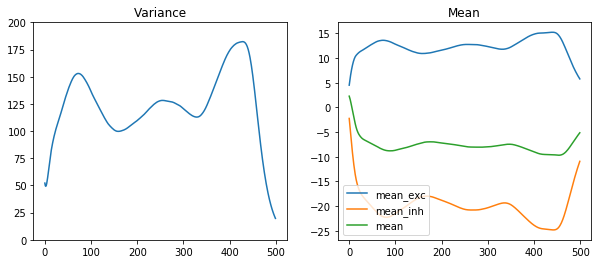

In [19]:
state_exc = net.exc.state
state_inh = net.inh.state
M = np.mean(net.exc.phi(state_exc)**2, axis=0)

r_sum_exc = conn_EE.W.dot(net.exc.phi(state_exc))
r_sum_inh = conn_EI.W.dot(net.inh.phi(state_inh))

field_var = (conn_EE.W.dot(net.exc.phi(state_exc)) + conn_EI.W.dot(net.inh.phi(state_inh))).var(axis=0)
field_mean_exc = r_sum_exc.mean(axis=0)
field_mean_inh = r_sum_inh.mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(field_var)
ax[1].plot(field_mean_exc, label="mean_exc")
ax[1].plot(field_mean_inh, label="mean_inh")
ax[1].plot(field_mean_exc+field_mean_inh, label="mean")
ax[0].set_ylim([0,200]);
ax[0].set_title("Variance")
ax[1].set_title("Mean")
plt.legend();